# Identifying Serious Cases of Colic in Equines

---

## Logistic Regression classifier for identifying cases of colic in horses which may result in required surgery or death, based on animal evaluation by a veterinarian.

## Goal:

Colic is a broad term used to describe gastrointestinal distress in horses. It often has a sudden onset and can be caused by a myriad of reasons. It is not always easily diagnosed and the seriousness of the problem can often escalate quickly and lead to necessary surgical intervention or death of the animal. The American Horse Council advises that colic causes the death of approximately 64,000 horses in the United States annually. 

Yeager Biomedical Data Analytics has created a Logistic Regression Classifier model to assist equine facility staff, as well as veterinarians in identifying cases in which horses are at high risk of death, as well as cases in which surgical intervention may be an optimal solution. The model takes into account medical evaluation data from the subject and produces an output whereby:

1. - Death is the likely outcome.
2. - Surgical intervention is the required solution to fix the problem.

Using the outcome of these models, it is our hope that horse care staff will be able to validate their suspicions and more accurately, aggressively, and quickly treat the conditions of horses experiencing colic. 

---

# Exploratory Analysis of the data

This dataset used in this analysis is located on the UCI machine learning repository https://archive.ics.uci.edu/ml/datasets/Horse+Colic. The data for a study like this is fairly rare and additional sources proved difficult to locate. This data consists of 368 records of horses which were experiencing colic and evaluated by veterinarians. This information was then compiled by the University of Guelph. While small, a total of 27 features are included with each record to assist in bolstering the strength of the dataset for model creation. 

Our target variables in the creation of these models will be:
    Outcome - whether the horse lived or died.
    Surgical Lesion - A retrospective finding, made either as a result of surgery or via autopsy, which states whether or                         not the horse's life could have been saved by surgery.
    
The other features within our dataset can be seen below in the following correlogram:

<img src="Images/CorrChart.png">

We can see that our target variable of death has a moderately strong correlation with several features. Surgical outcome is less correlated. Below are the top 5 strongest correlations between our targets and features:

Top five features which correlate strongest with death
    type of lesion                                           0.480634
    packed cell volume                                       0.377041
    pulse                                                    0.371072
    mucous membranes                                         0.353489
    pain  a subjective judgement of the horses pain level    0.274032

---

Top five features which correlate strongest with required surgery
    surgery                  0.611526
    total protein            0.021298
    rectal temperature       0.014883
    Age                     -0.049852
    capillary refill time   -0.074508

Some basic breakdowns within our dataset can be seen below. We see a pretty even breakdown between the counts of surgery and death, but does this translate literally? One of our goals is to assist individuals in deciding to conduct surgery as an intervention. Lets see how that breaks down further to understand if there is room for improvement.

<table><tr>
<td> <img src="Images/Mortality.png" style="width: 500px;"/> </td>
<td> <img src="Images/SurgeryYN.png" style="width: 500px;"/> </td>
</tr></table>

Here we see that out of all cases in which surgery was not performed, that it was later revealed (usually via autopsy) that a surgical intervention would have prodiced a posative outcome for the animal in 28% of cases. This 28% comprises the cases which we will be attempting to improve upon.

<img src="Images/SurgicalBreakdown.png"/>

<p style="width: 300px;">Looking into this even further, we filter our dataset to see specifically those cases in which the patient dies after surgery is NOT performed, but it is later found out that surgery was, in fact, needed. The accompanying chart tells us that in 69% of these cases, surgery could have potentially saved the animal. Additional room fr our model to assist these medical personell in decision making.</p>
<img src="Images/DeathSurgeryNeededNotDone.png" style="width: 700px;"/> </td>


# Creating our First Model: 
## Logistic Regression Classifier for Death Outcome.

In [524]:
#Import all necesary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from textwrap import wrap
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression ## import model
from sklearn import metrics
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import binarize

Detailed information on how this dataset was processed can be found within the notebook:
    https://github.com/yeagercmbpd/Identifying-Serious-Cases-of-Colic-in-Equines/blob/main/Notebooks/Project%201%20Data%20Preparation.ipynb

In [525]:
#Read pre processed data into pandas df and drop the index column that comes in from the spreadsheet
df=pd.read_excel('Data/HorseColicData_DeathTarget.xlsx',index=False)
df=df.drop('Unnamed: 0',axis=1)
df.shape

(368, 19)

In [526]:
df.head()

,surgery,Age,rectal temperature,pulse,respiratory rate,temperature of extremities,peripheral pulse,mucous membranes,capillary refill time,pain a subjective judgement of the horses pain level,peristalsis,abdominal distension,packed cell volume,total protein,outcome,surgical lesion,type of lesion,Target,location of lesion
0,2,1,38.5,66,28,3,3,0,2,5,4,4,45.0,1,2,2,1,1,1
1,1,1,39.2,88,20,0,0,4,1,3,4,2,50.0,1,3,2,2,1,2
2,2,1,38.3,40,24,1,1,3,1,3,3,1,33.0,0,1,2,0,0,0
3,1,9,39.1,164,84,4,1,6,2,2,4,4,48.0,0,2,1,2,1,2
4,2,1,37.3,104,35,0,0,6,2,0,0,0,74.0,0,2,2,3,1,4


In [527]:
#Verify binary outcome of target variable
SimpleBinary=df
SimpleBinary['Target'].value_counts()

0    227
1    141
Name: Target, dtype: int64

For this model, I have decided to take the additional step of creating a holdout dataset. This will be used as the final test of our finished model and should provide us with the most accurate measure of its effectiveness, as the model will have never seen this data before. 25 records are randomaly selected from our dataframe and removed.

In [528]:
HoldoutSet=SimpleBinary.sample(n=25)

SimpleBinary=SimpleBinary.merge(HoldoutSet, how = 'outer' ,indicator=True).loc[lambda x : x['_merge']=='left_only']

SimpleBinary=SimpleBinary.drop('_merge',axis=1)
SimpleBinary.shape

(343, 19)

In [529]:
#Final check to ensure no nan values
SimpleBinary.isna().sum()

surgery                                                  0
Age                                                      0
rectal temperature                                       0
pulse                                                    0
respiratory rate                                         0
temperature of extremities                               0
peripheral pulse                                         0
mucous membranes                                         0
capillary refill time                                    0
pain  a subjective judgement of the horses pain level    0
peristalsis                                              0
abdominal distension                                     0
packed cell volume                                       0
total protein                                            0
outcome                                                  0
surgical lesion                                          0
type of lesion                                          

In [530]:
#Create features for model consumption and drop target
X = SimpleBinary.drop(columns= ['outcome','Target'])
X.columns

Index(['surgery', 'Age', 'rectal temperature', 'pulse', 'respiratory rate',
       'temperature of extremities', 'peripheral pulse', 'mucous membranes',
       'capillary refill time',
       'pain  a subjective judgement of the horses pain level', 'peristalsis',
       'abdominal distension', 'packed cell volume', 'total protein',
       'surgical lesion', 'type of lesion', 'location of lesion'],
      dtype='object')

In [531]:
#Create target variable for model consumption
y = SimpleBinary.Target 
y.value_counts()

0    210
1    133
Name: Target, dtype: int64

Split the data into train and test, with a test size of 25% of the total dataset. randomstate 40 is used for reproducability of exercise. instantiate the logistic regression model and fit the training data to it. 

In [532]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = .25, random_state = 40)

logreg = LogisticRegression(penalty = 'none', max_iter= 10000,random_state = 40)

logreg.fit(X_train, Y_train) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=40, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [533]:
#Check the accuracy scores of the classification model using the test data
score = logreg.score(X_test,Y_test)
score

0.7325581395348837

In [534]:
#Use model to make predictions from test set
predictions = logreg.predict(X_test)

In [535]:
#Get the actual probabilties for each prediction
probabilities= logreg.predict_proba(X_test)

In order to more fully understand how the model makes its predictions, we will take a look at the probabilities which are generated for each case. These are formatted and read into the new dataframe Chartdf below.

In [536]:
problive=[]
probdie=[]
for i in range(len(probabilities)):
    problive.append(probabilities[i][0])
    probdie.append(probabilities[i][1])

In [537]:
ModelChart = {'live':problive,'die':probdie,'predictedoutcome':list(predictions)}
Chartdf = pd.DataFrame(ModelChart)

In [538]:
Chartdf['predictedoutcome'].replace(to_replace =0, value ="Lives",inplace=True)
Chartdf['predictedoutcome'].replace(to_replace =1, value ="Dies",inplace=True)

In [539]:
Chartdf

,live,die,predictedoutcome
0,0.869425,0.130575,Lives
1,0.240867,0.759133,Dies
2,0.840896,0.159104,Lives
3,0.744005,0.255995,Lives
4,0.936951,0.063049,Lives
...,...,...,...
81,0.854864,0.145136,Lives
82,0.882977,0.117023,Lives
83,0.232623,0.767377,Dies
84,0.949338,0.050662,Lives


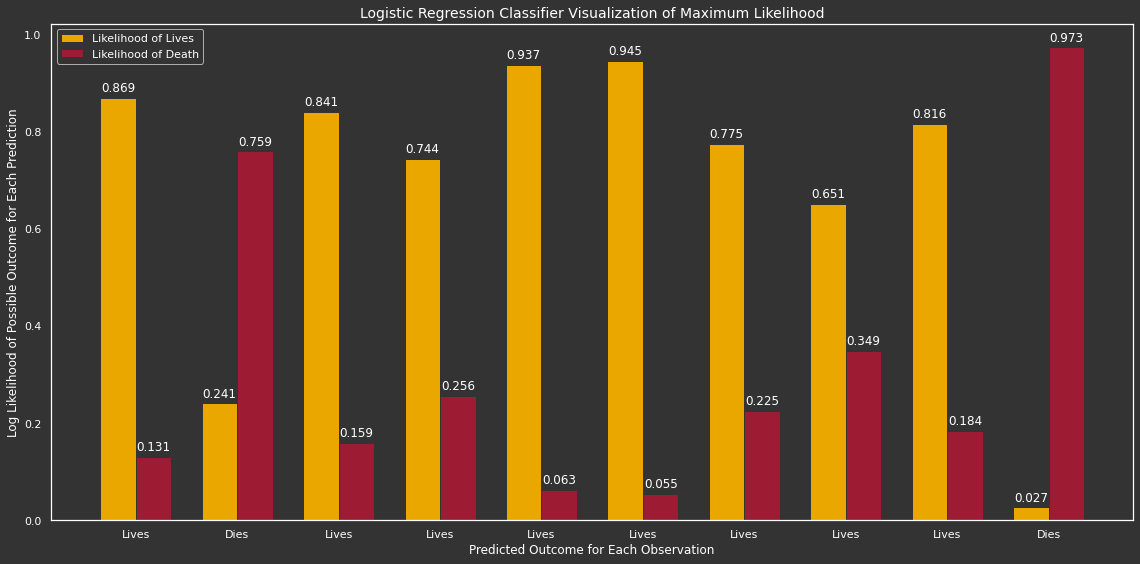

In [540]:
#Some styling assistance from matplotlib example docs
#https://matplotlib.org/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py

sns.set(rc={'axes.facecolor':'#333333', 'figure.facecolor':'#333333'})
plt.rcParams['font.sans-serif'] = 'montserrat'
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor']= 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'

plt.rcParams['patch.edgecolor'] = '#333333'

labels = Chartdf[0:10]['predictedoutcome'].astype(str)
labels = [ '\n'.join(wrap(l, 12)) for l in labels ]

men_means = Chartdf[0:10]['live'].round(3)
women_means = Chartdf[0:10]['die'].round(3)

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(16, 8))

rects1 = ax.bar(x - width/2, men_means, width, label='Likelihood of Lives',color=['#EAA700'])
rects2 = ax.bar(x + width/2, women_means, width, label='Likelihood of Death',color=['#9E1B34'])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Log Likelihood of Possible Outcome for Each Prediction')
ax.set_xlabel('Predicted Outcome for Each Observation')
ax.set_title('Logistic Regression Classifier Visualization of Maximum Likelihood',size=14)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

ax.grid(False)

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()
fig.savefig('LikelihoodChart.png',transparent=False,dpi=100,bbox_inches='tight', facecolor=('#333333'))

Above we see a graphical representation of the first ten predictions made by the model. Logistic Regression classifiers function based on the idea of maximum likelihood. This means that the function generates a probability of the two possible outcomes for each observation. Based on these probabilities, a decision is made on what the predicted outcome will be. we can also sum the likelihood function across all observations in the dataset to maximize the likelihood, the ultimate goal of our model. 

In [541]:
#Generate a confusion matrix for the test data and predictions for the above model. code from class examples
cm = metrics.confusion_matrix(Y_test, predictions)

In the below confusion matrix we see an overall prediction accuracy of approximately 73%. False negative outcomes outweigh false posative outcomes at 14 vs 9. In our use case we would prefer the opposite, as we would rather err on the side of caution rather than predicting that the patient will live, when in fact they will not.

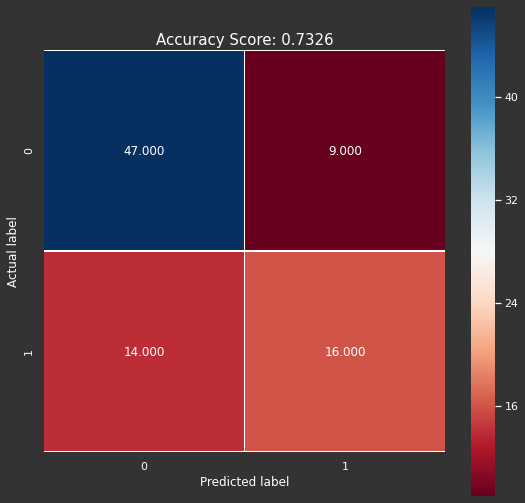

In [542]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'RdBu');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score.round(4))
plt.title(all_sample_title, size = 15);
plt.savefig('Images/LogRegDeath1.png',transparent=False,dpi=100,bbox_inches='tight', facecolor=('#333333'))
plt.show()

---

## Feature Selection.

We will now attempt to do some feature selection, removing potential noise, reducing the chance of overfitting, and simplifying the model. In this first step we will simply remove those features with a correlation of less than .1 to the target feature.

In [543]:
#remove values with correlation less than .1
Corrs=SimpleBinary[SimpleBinary.columns].corr()['Target']
#account for negative correlation
remove2=Corrs[np.sqrt(Corrs**2) < 0.1].index

In [544]:
remove2

Index(['Age', 'rectal temperature', 'respiratory rate', 'total protein'], dtype='object')

In [545]:
SimpleBinary2=SimpleBinary.drop(list(remove2), axis=1)
SimpleBinary2.head()

,surgery,pulse,temperature of extremities,peripheral pulse,mucous membranes,capillary refill time,pain a subjective judgement of the horses pain level,peristalsis,abdominal distension,packed cell volume,outcome,surgical lesion,type of lesion,Target,location of lesion
0,2,66,3,3,0,2,5,4,4,45.0,2,2,1,1,1
1,1,88,0,0,4,1,3,4,2,50.0,3,2,2,1,2
2,2,40,1,1,3,1,3,3,1,33.0,1,2,0,0,0
3,1,164,4,1,6,2,2,4,4,48.0,2,1,2,1,2
4,2,104,0,0,6,2,0,0,0,74.0,2,2,3,1,4


We will now refit the model with these variables removed following the same steps as the first time and reassess its performance.

In [546]:
X = SimpleBinary2.drop(columns= ['outcome','Target'])
X.columns

Index(['surgery', 'pulse', 'temperature of extremities', 'peripheral pulse',
       'mucous membranes', 'capillary refill time',
       'pain  a subjective judgement of the horses pain level', 'peristalsis',
       'abdominal distension', 'packed cell volume', 'surgical lesion',
       'type of lesion', 'location of lesion'],
      dtype='object')

In [547]:
y = SimpleBinary2.Target
y.value_counts()

0    210
1    133
Name: Target, dtype: int64

In [548]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = .25, random_state = 40)

logreg = LogisticRegression(penalty = 'none', max_iter= 10000,random_state = 40) 

logreg.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=40, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [549]:
## Accuracy Scores
trainscore = logreg.score(X_train,Y_train)
testscore = logreg.score(X_test,Y_test)

print('train score')
print(trainscore)
print('test score')
print(testscore)

train score
0.7470817120622568
test score
0.7674418604651163


In [550]:
#Make predictions from test using new model
predictions = logreg.predict(X_test)

In [551]:
cm = metrics.confusion_matrix(Y_test, predictions)

We observe a slightly increased test accuracy based on the removal of the above variables.

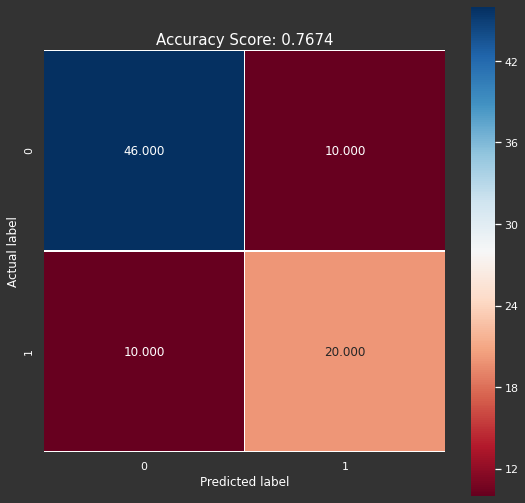

In [552]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'RdBu');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(testscore.round(4))
plt.title(all_sample_title, size = 15);
plt.savefig('Images/LogRegDeath2.png',transparent=False,dpi=100,bbox_inches='tight', facecolor=('#333333'))
plt.show()

---

Now we will attempt feature selection using the lasso meathod, as opposed to simply discarding the variables with low correlation to target.

In [612]:
#Create featureset from our original dataframe will all variables present, discard targets
X = SimpleBinary.drop(columns= ['outcome','Target'])
X.columns

Index(['surgery', 'Age', 'rectal temperature', 'pulse', 'respiratory rate',
       'temperature of extremities', 'peripheral pulse', 'mucous membranes',
       'capillary refill time',
       'pain  a subjective judgement of the horses pain level', 'peristalsis',
       'abdominal distension', 'packed cell volume', 'total protein',
       'surgical lesion', 'type of lesion', 'location of lesion'],
      dtype='object')

In [613]:
y = SimpleBinary.Target ## creating target values
y.value_counts()

0    210
1    133
Name: Target, dtype: int64

In [614]:
#Train test split with 25% test set, same random state
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = .25, random_state = 40)

Below is a visual representation of the feature importance as derived from their coefficient value. Lasso regression has the ability to drive the coeficient values down to actual zero. We will select out those features which have a coefficient value greater than zero and once again rebuild our model from that data frame.

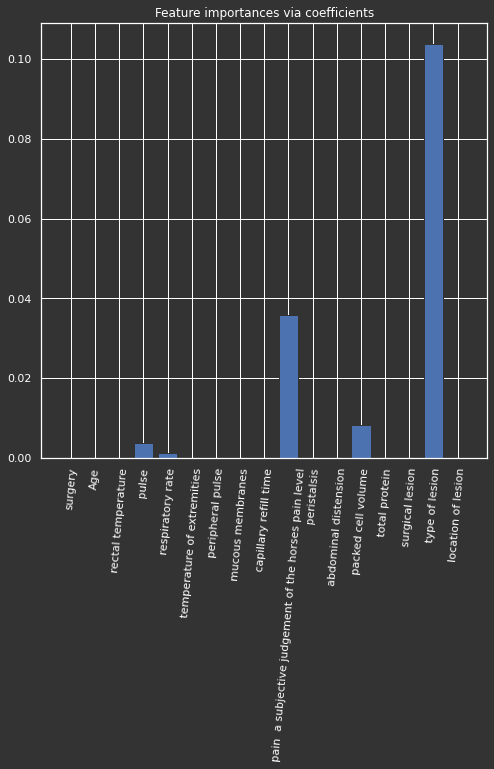

In [615]:
#Assistance from https://github.com/justmarkham/scikit-learn-videos

plt.rcParams["figure.figsize"] = (8,8)

lasso = LassoCV().fit(X_train, Y_train)
importance = np.abs(lasso.coef_)
#feature_names = np.array(X_train.values)
plt.bar(height=importance, x=X_train.columns)
plt.xticks(rotation=85)
plt.title("Feature importances via coefficients")
plt.savefig('Lasso.png',transparent=False,dpi=100,bbox_inches='tight', facecolor=('#333333'))
plt.show()

In [616]:
#Dataframe containing the coefficients from the above lassocv model
LassoOutcome = {'feature':X_train.columns,'importance':list(importance)}
LassoOutcome = pd.DataFrame(LassoOutcome)
LassoOutcome

,feature,importance
0,surgery,0.000000
1,Age,0.000000
2,rectal temperature,0.000000
3,pulse,0.003750
4,respiratory rate,0.001225
5,temperature of extremities,0.000000
6,peripheral pulse,0.000000
7,mucous membranes,0.000000
8,capillary refill time,0.000000
9,pain a subjective judgement of the horses pai...,0.035768


In [617]:
#remove values with importance of 0
Lassoremove=LassoOutcome[LassoOutcome['importance'] == 0]
list(Lassoremove['feature'])

['surgery',
 'Age',
 'rectal temperature',
 'temperature of extremities',
 'peripheral pulse',
 'mucous membranes',
 'capillary refill time',
 'peristalsis',
 'abdominal distension',
 'total protein',
 'surgical lesion',
 'location of lesion']

In [618]:
SimpleBinary3=SimpleBinary.drop(list(Lassoremove['feature']), axis=1)
SimpleBinary3.head()

,pulse,respiratory rate,pain a subjective judgement of the horses pain level,packed cell volume,outcome,type of lesion,Target
0,66,28,5,45.0,2,1,1
1,88,20,3,50.0,3,2,1
2,40,24,3,33.0,1,0,0
3,164,84,2,48.0,2,2,1
4,104,35,0,74.0,2,3,1


Now lets retrain the classifier model using these features.

In [619]:
X = SimpleBinary3.drop(columns= ['outcome','Target'])
#X = pd.get_dummies(X)
X.columns

Index(['pulse', 'respiratory rate',
       'pain  a subjective judgement of the horses pain level',
       'packed cell volume', 'type of lesion'],
      dtype='object')

In [620]:
y = SimpleBinary3.Target ## creating target values
y.value_counts()

0    210
1    133
Name: Target, dtype: int64

In [621]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = .25, random_state = 40)

logreg = LogisticRegression(penalty = 'none', max_iter= 10000,random_state = 40)

logreg.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=40, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [622]:
## Accuracy Scores
trainscore = logreg.score(X_train,Y_train)
testscore = logreg.score(X_test,Y_test)

print(trainscore)
print(testscore)

0.7470817120622568
0.7906976744186046


In [623]:
predictions = logreg.predict(X_test)

In [624]:
cm = metrics.confusion_matrix(Y_test, predictions)

We now observe a test accuracy greater than that of the baseline with the removal of the above variables identified by the lasso regression. Excluding uneeded features makes for a better model and we will now use this dataset moving forward for parameter testing and final evaluation.

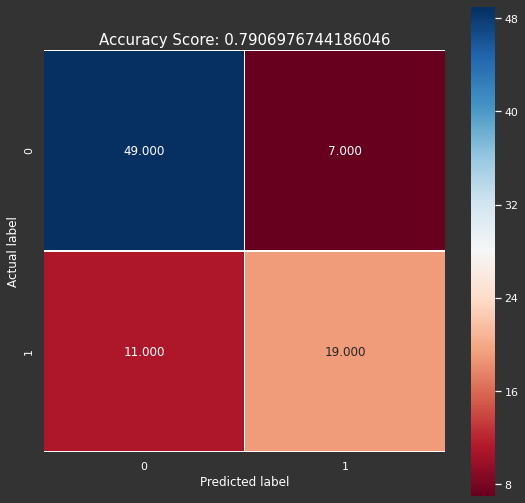

In [625]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'RdBu');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(testscore)
plt.title(all_sample_title, size = 15);
plt.savefig('Images/LogRegDeath3.png',transparent=False,dpi=100,bbox_inches='tight', facecolor=('#333333'))
plt.show()

## Validating the Model

Validating the model via Cross Validation, k folds used as dataset isnt huge orig run time * k times. this is a more accurate measurment of model accracy
Source used for assistance in coding:https://github.com/justmarkham/scikit-learn-videos/blob/master/07_cross_validation.ipynb
and 
https://github.com/justmarkham/scikit-learn-videos/blob/master/09_classification_metrics.ipynb

In [626]:
#Below is a visualization of how the folds used in this method will be evaluated, 
#splitting out the test and train data for each fold, or iteration
kf = KFold(n_splits=10, shuffle=False).split(range(len(SimpleBinary3)))

# print the contents of each training and testing set
print('{} {:^61} {}'.format('Iteration', 'Training set observations', 'Testing set observations'))
for iteration, data in enumerate(kf, start=1):
    print('{:^9} {} {:^25}'.format(iteration, data[0], str(data[1])))

Iteration                   Training set observations                   Testing set observations
    1     [ 35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124
 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142
 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160
 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178
 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196
 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214
 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232
 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250
 251 252 253 254 

In [627]:
# 10-fold cross-validation using the most up to date version of our model logreg
scores = cross_val_score(logreg, X, y, cv=10, scoring='accuracy')
print(scores)

[0.85714286 0.77142857 0.74285714 0.76470588 0.76470588 0.64705882
 0.73529412 0.64705882 0.79411765 0.67647059]


In [628]:
#The scores for these ten folds are now averaged to come up with the final score for the model
print(scores.mean())

0.7400840336134454


Now that we have our final dataset and a measure of the accuracy of our model, we can use the follwing functions to fine tune the parameters of the logistic regression classifier to obtain the best possible results from our model. Each step below utilizes a final accuracy measure of a k fold cross validation of 10.

Cfloat, default=1.0
Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.

In [629]:
Cvals=[0.001,0.01,0.1,1,10,100]
k_scores = []
for c in Cvals:
    logreg = LogisticRegression(max_iter= 10000,random_state = 40,C=c)

    scores = cross_val_score(logreg, X, y, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
print(k_scores)

[0.7198319327731093, 0.7373949579831933, 0.7461344537815127, 0.7400840336134454, 0.7400840336134454, 0.7400840336134454]


In [630]:
#Select the C value with the best outcome
BestC=Cvals[k_scores.index(max(k_scores))]

solver{‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, default=’lbfgs’
Algorithm to use in the optimization problem.

In [631]:
solve = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
k_scores = []
for s in solve:
    logreg = LogisticRegression(max_iter= 1000000,random_state = 40,solver=s,C=BestC) ## instantiate

    scores = cross_val_score(logreg, X, y, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
print(k_scores)

[0.7461344537815127, 0.7461344537815127, 0.7078991596638655, 0.7049579831932773, 0.7020168067226891]


In [632]:
#Select the solver with the best outcome
BestS=solve[k_scores.index(max(k_scores))]

In [633]:
# 10-fold cross-validation using the parameters which the above functions produced
logreg = LogisticRegression(max_iter= 1000000,random_state = 40,C=BestC,solver=BestS) ## instantiate
logreg.fit(X_train, Y_train) ## fit
scores = cross_val_score(logreg, X, y, cv=10, scoring='accuracy')
print(scores.mean())

0.7461344537815127


A reduction in accuracy is noted in modifying these parameters, so we will revert to the original model.

In [636]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = .25, random_state = 40)

logreg = LogisticRegression(penalty = 'none', max_iter= 10000,random_state = 40)

logreg.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=40, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [637]:
## Accuracy Scores
trainscore = logreg.score(X_train,Y_train)
testscore = logreg.score(X_test,Y_test)

print(trainscore)
print(testscore)

0.7470817120622568
0.7906976744186046


One final way to measure the true effectiveness of our model is to consider the distribution of the possible outcomes (life or death). Does out model predict simply based on the numerical split/distribution within the data, or is it more accurate than that?

In [638]:
#Checking null accuracy
print(Y_test.value_counts().head(2) / len(Y_test))

0    0.651163
1    0.348837
Name: Target, dtype: float64


In [639]:
# the split of death to life, as visualized in the graph above. Our test data predictions differ from this.
y.value_counts().head(2) / len(y)

0    0.612245
1    0.387755
Name: Target, dtype: float64

A prediction of outcomes does not simply follow the distribtuon percentage of the targets within the dataset, a posative outcome.

---

The final manual parameter which we could adjust to achieve greater accuracy would be to alter the final prediction output of the model based on the likelihood output. In other words, a likelihood greater than the defualt .5 can be specified when making the final prediction off of the proability array. This is the final parameter which should be considered and only once the final model and features have been selected. It is often a matter of domain knowledge. For us we will see if weighting a "death" outcome can allow us to reduce the number of false negative results. erring on the side of caution for the model used by veteranarians so that they be more lean towards more aggressive medical intervention when death could be a result of the evaluation of the horse.

In [640]:
# make class predictions for the testing set
y_pred_class = logreg.predict(X_test)

In [641]:
print('Actual Outcome:   ', Y_test.values[0:25])
print('Predicted Outcome:', y_pred_class[0:25])

Actual Outcome:    [1 1 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 1 0 0 0]
Predicted Outcome: [0 1 0 0 0 0 0 0 0 1 0 1 0 1 1 1 1 0 1 0 0 1 0 0 0]


Below we see the distribution of the predicted outcomes. Now lets see how shifting the classifier threshold could change our model.

In [642]:
y_pred_prob = logreg.predict_proba(X_test)[:, 1]

Text(0, 0.5, 'Frequency')

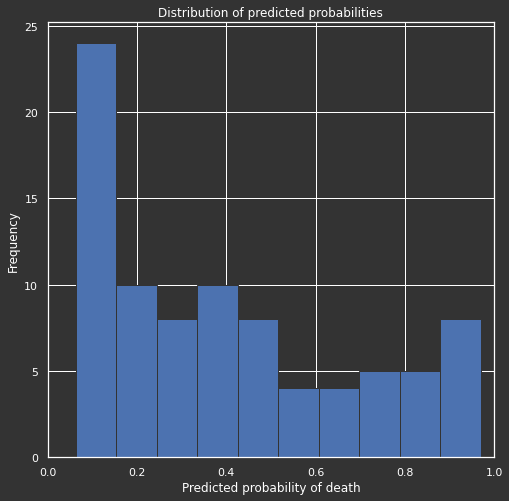

In [643]:
plt.hist(y_pred_prob, bins=10)
plt.xlim(0, 1)
plt.title('Distribution of predicted probabilities')
plt.xlabel('Predicted probability of death')
plt.ylabel('Frequency')

In [644]:
#generate a list of possible weights between .4 and .6
PossibleWeights=np.arange(.4, .6, 0.01).tolist()

In [645]:
#Simple loop for finding the weight which produces the greatest acuracy
BestAccuracy=[]
for i in range(len(PossibleWeights)):
    BestAccuracy.append(metrics.accuracy_score(Y_test, binarize([y_pred_prob], PossibleWeights[i])[0]))

In [646]:
Bestweight=PossibleWeights[BestAccuracy.index(max(BestAccuracy))]
Bestweight

0.4800000000000001

In [647]:
#Simple loop for finding the weight which produces the least number of false negatives (predict life when death)

lowfalseneg=[]
for i in range(len(PossibleWeights)):
    lowfalseneg.append(metrics.confusion_matrix(Y_test,binarize([y_pred_prob], PossibleWeights[i])[0])[1][0])

In [648]:
LowestFalseNegative=PossibleWeights[lowfalseneg.index(min(lowfalseneg))]
LowestFalseNegative

0.4

In [649]:
print('Lowest false negative count possible: ' + str(min(lowfalseneg)))

Lowest false negative count possible: 9


In [650]:
y_pred_classAccuracy=binarize([y_pred_prob], Bestweight)

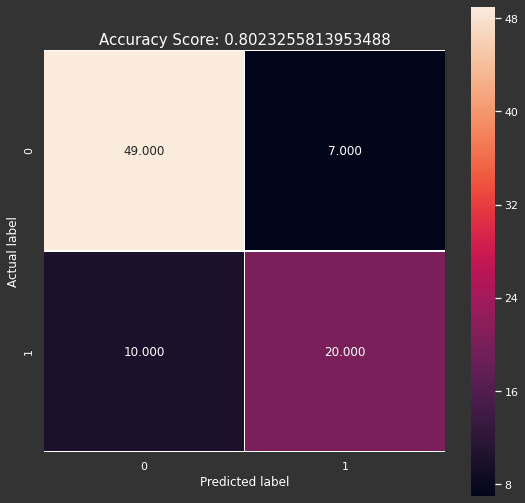

In [651]:
plt.figure(figsize=(9,9))
sns.heatmap((metrics.confusion_matrix(Y_test, y_pred_classAccuracy[0])), annot=True, fmt=".3f", linewidths=.5, square = True);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format((metrics.accuracy_score(Y_test, y_pred_classAccuracy[0])))
plt.title(all_sample_title, size = 15);
plt.savefig('Images/LogRegDeath4.png',transparent=False,dpi=100,bbox_inches='tight', facecolor=('#333333'))
plt.show()

In [652]:
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Specificity:', 1 - fpr[thresholds > threshold][-1])
evaluate_threshold(Bestweight)


Sensitivity: 0.6666666666666666
Specificity: 0.875


In [655]:
y_pred_classlowfalseneg=binarize([y_pred_prob], LowestFalseNegative)

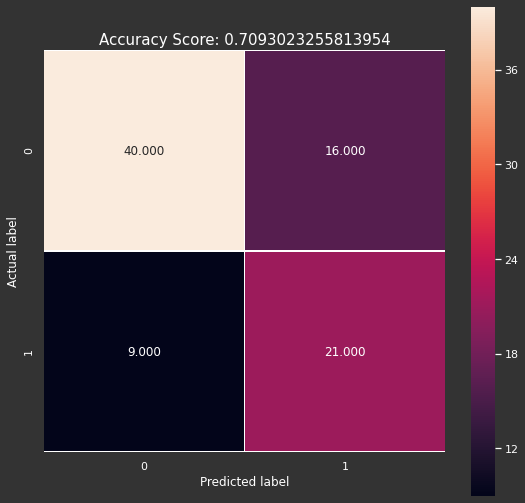

In [656]:
plt.figure(figsize=(9,9))
sns.heatmap((metrics.confusion_matrix(Y_test, y_pred_classlowfalseneg[0])), annot=True, fmt=".3f", linewidths=.5, square = True);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format((metrics.accuracy_score(Y_test, y_pred_classlowfalseneg[0])))
plt.title(all_sample_title, size = 15);
plt.savefig('Images/LogRegDeath5.png',transparent=False,dpi=100,bbox_inches='tight', facecolor=('#333333'))
plt.show()

Not finding any major gains in accuracy and losing a good bit of accuracy to acheive the lowest possible outcome of false negatives, we will refrain from modfying the model in this way. The default split of .5 will be retained

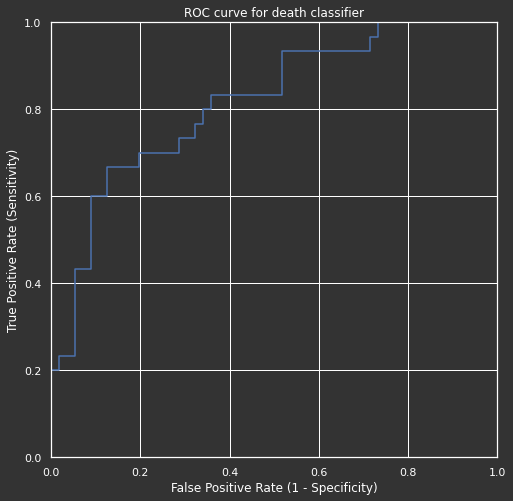

In [657]:
#Using the ROC curve to check final performance of model. Maximizing the area under this curve is the goal.
fpr, tpr, thresholds = metrics.roc_curve(Y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for death classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

Checking area under curve as alternative to classification accuracy. Maximizing the area under the curve, a score closest to 1 indicates a strong classifier model. 

In [658]:
print(metrics.roc_auc_score(Y_test, y_pred_prob))

0.8154761904761905


In [659]:
cross_val_score(logreg, X, y, cv=10, scoring='roc_auc').mean()

0.8160910518053377

## Checking the Holdout Set

In [595]:
HoldoutSet=HoldoutSet.drop(list(Lassoremove['feature']), axis=1)


In [661]:
X = HoldoutSet.drop(columns= ['outcome','Target'])
X.columns

Index(['pulse', 'respiratory rate',
       'pain  a subjective judgement of the horses pain level',
       'packed cell volume', 'type of lesion'],
      dtype='object')

In [662]:
y = HoldoutSet.Target ## creating target values
y.value_counts()

0    17
1     8
Name: Target, dtype: int64

In [663]:
holscore = logreg.score(X,y)
print(trainscore)

0.7470817120622568


In [664]:
predictions = logreg.predict(X)
predictions


array([0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0], dtype=int64)

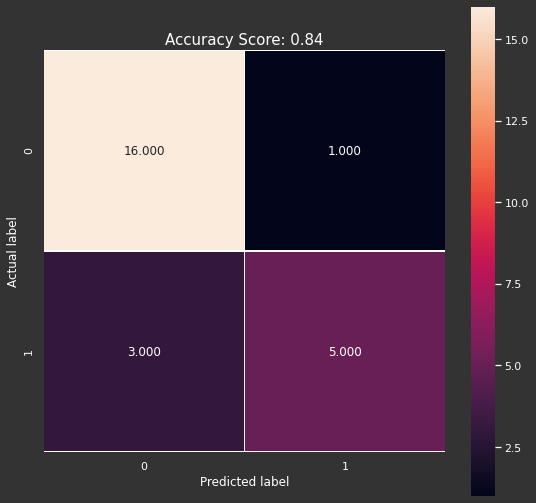

In [665]:
metrics.confusion_matrix(y, logreg.predict(X))


plt.figure(figsize=(9,9))
sns.heatmap(metrics.confusion_matrix(y, logreg.predict(X)), annot=True, fmt=".3f", linewidths=.5, square = True);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format((metrics.accuracy_score(y, logreg.predict(X))))
plt.title(all_sample_title, size = 15);
plt.savefig('confusionmatrix_DeathHoldoutData.png',transparent=False,dpi=100,bbox_inches='tight', facecolor=('#333333'))
plt.show()

In this instance, our model was able to predict the likely death of the patient with an accuracy of 84%, based off of a totally new dataset. A promising result.

# Creating our Second Model: 
## Logistic Regression Classifier for Surgical Outcome.

For the purposes of this model, we will be following many of the same steps above. Some individual explaination of each step will be omitted for the sake of redundancy. Whereas the above classifier was made to predict a possible outcome of death and thereby seriousness of the event, this model will focus on whether or not doing surgery on the animal could save its life based on the initial evaluation by a veterenarian. 

In [218]:
#Read pre processed data into pandas df and drop the index column that comes in from the spreadsheet
df=pd.read_excel('Data/HorseColicData_DeathTarget.xlsx',index=False)
df=df.drop('Unnamed: 0',axis=1)

Verify target variable has only 2 possible values and recode to 0 or 1

In [219]:
SimpleBinary=df
SimpleBinary['surgical lesion'].value_counts()

1    232
2    136
Name: surgical lesion, dtype: int64

In [220]:
SimpleBinary['surgical lesion'].replace(to_replace =1, value =0,inplace=True)
SimpleBinary['surgical lesion'].replace(to_replace =2, value =1,inplace=True)

For this model, I have decided to take the additional step of creating a holdout dataset. This will be used as the final test of our finished model and should provide us with the most accurate measure of its effectiveness, as the model will have never seen this data before. 25 records are randomaly selected from our dataframe and removed.

In [221]:
HoldoutSet=SimpleBinary.sample(n=25)

SimpleBinary=SimpleBinary.merge(HoldoutSet, how = 'outer' ,indicator=True).loc[lambda x : x['_merge']=='left_only']

SimpleBinary=SimpleBinary.drop('_merge',axis=1)
SimpleBinary.shape

(342, 19)

In [222]:
#set from the preprocessed data Target contains outcome we'll write this back to its original position for use as a feature
SimpleBinary['outcome'] = SimpleBinary['Target']
#Set new target
SimpleBinary['Target'] = SimpleBinary['surgical lesion']

SimpleBinary=SimpleBinary.astype(float)

In [223]:
#set features and remove target
X = SimpleBinary.drop(columns= ['surgical lesion','Target'])
X.columns

Index(['surgery', 'Age', 'rectal temperature', 'pulse', 'respiratory rate',
       'temperature of extremities', 'peripheral pulse', 'mucous membranes',
       'capillary refill time',
       'pain  a subjective judgement of the horses pain level', 'peristalsis',
       'abdominal distension', 'packed cell volume', 'total protein',
       'outcome', 'type of lesion', 'location of lesion'],
      dtype='object')

In [224]:
y = SimpleBinary.Target ## creating target values

Split the data into train and test, with a test size of 25% of the total dataset. randomstate 40 is used again for reproducability of exercise and consistency. instantiate the logistic regression model and fit the training data to it. 

In [225]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = .15, random_state = 40)

logreg = LogisticRegression(penalty = 'none', max_iter= 10000,random_state = 40) 

logreg.fit(X_train, Y_train) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=40, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [226]:
#Check the accuracy scores of the classification model using the test data
score = logreg.score(X_test,Y_test)
score

0.8846153846153846

In [227]:
#make predictions from the test data
predictions = logreg.predict(X_test)

In the below confusion matrix we see an overall prediction accuracy of approximately 88%. 2 false negative outcomes and 4 false posatives are observed

In [228]:
cm = metrics.confusion_matrix(Y_test, predictions)

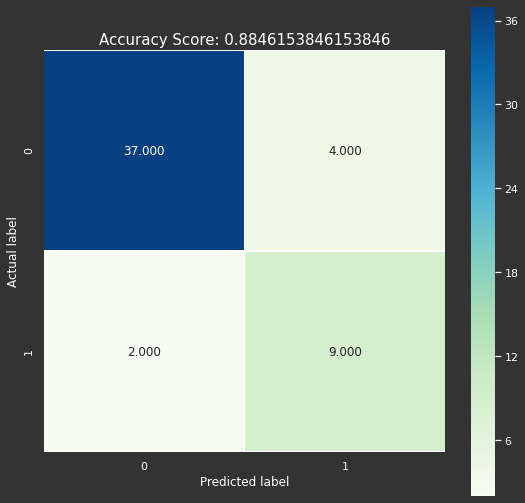

In [229]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'GnBu');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);
plt.savefig('Images/LogRegSurgery1.png',transparent=False,dpi=100,bbox_inches='tight', facecolor=('#333333'))
plt.show()

## Feature selection

We will down attempt to do some feature selection, removing potential noise form uncorrelated variables. In this first step those features with a correlation of less than .1 to the target feature are removed from the dataframe.

In [230]:
#remove values with correlation less than .1
Corrs=SimpleBinary[SimpleBinary.columns].corr()['outcome']
remove2=Corrs[np.sqrt(Corrs**2) < 0.1].index

In [231]:
remove2

Index(['Age', 'rectal temperature', 'respiratory rate', 'total protein'], dtype='object')

In [232]:
SimpleBinary2=SimpleBinary.drop(list(remove2), axis=1)
SimpleBinary2

,surgery,pulse,temperature of extremities,peripheral pulse,mucous membranes,capillary refill time,pain a subjective judgement of the horses pain level,peristalsis,abdominal distension,packed cell volume,outcome,surgical lesion,type of lesion,Target,location of lesion
0,2.0,66.0,3.0,3.0,0.0,2.0,5.0,4.0,4.0,45.0,1.0,1.0,1.0,1.0,1.0
1,1.0,88.0,0.0,0.0,4.0,1.0,3.0,4.0,2.0,50.0,1.0,1.0,2.0,1.0,2.0
2,2.0,40.0,1.0,1.0,3.0,1.0,3.0,3.0,1.0,33.0,0.0,1.0,0.0,1.0,0.0
3,1.0,164.0,4.0,1.0,6.0,2.0,2.0,4.0,4.0,48.0,1.0,0.0,2.0,0.0,2.0
4,2.0,104.0,0.0,0.0,6.0,2.0,0.0,0.0,0.0,74.0,1.0,1.0,3.0,1.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,1.0,78.0,4.0,4.0,6.0,0.0,3.0,3.0,3.0,59.0,1.0,0.0,2.0,0.0,2.0
364,2.0,42.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,36.0,0.0,1.0,1.0,1.0,4.0
365,1.0,60.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,44.0,1.0,0.0,2.0,0.0,2.0
366,2.0,42.0,3.0,0.0,3.0,1.0,1.0,1.0,1.0,37.0,0.0,1.0,1.0,1.0,3.0


Run it again low corrs gone

In [233]:
X = SimpleBinary2.drop(columns= ['outcome','Target'])
#X = pd.get_dummies(X)
X.columns

Index(['surgery', 'pulse', 'temperature of extremities', 'peripheral pulse',
       'mucous membranes', 'capillary refill time',
       'pain  a subjective judgement of the horses pain level', 'peristalsis',
       'abdominal distension', 'packed cell volume', 'surgical lesion',
       'type of lesion', 'location of lesion'],
      dtype='object')

In [234]:
y = SimpleBinary2.Target ## creating target values
y.value_counts()

0.0    211
1.0    131
Name: Target, dtype: int64

In [235]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression ## import model


X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = .15, random_state = 40)

logreg = LogisticRegression(penalty = 'none', max_iter= 10000,random_state = 40) ## instantiate

logreg.fit(X_train, Y_train) ## fit

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=40, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [236]:
## Accuracy Scores
trainscore = logreg.score(X_train,Y_train)
testscore = logreg.score(X_test,Y_test)

print(trainscore)
print(testscore)

1.0
1.0


In [237]:
predictions = logreg.predict(X_test)

Accuracy is not detrementially impacted so we will go with this rather than using lasso again

In [238]:
cm = metrics.confusion_matrix(Y_test, predictions)

A greatly increased test accuracy based on the removal of the above variables is observed.

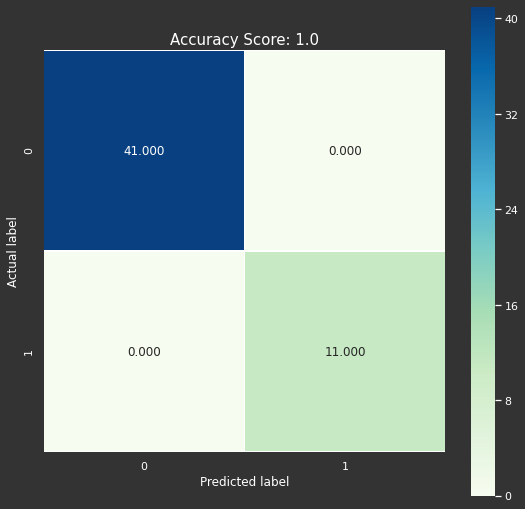

In [239]:
from sklearn import metrics

cm = metrics.confusion_matrix(Y_test, predictions)

import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'GnBu');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(testscore)
plt.title(all_sample_title, size = 15);
plt.savefig('Images/LogRegSurgery2.png',transparent=False,dpi=100,bbox_inches='tight', facecolor=('#333333'))
plt.show()

## K fold cross validation

Validating the model via Cross Validation, 10 folds used

In [240]:
# 10-fold cross-validation 
scores = cross_val_score(logreg, X, y, cv=10, scoring='accuracy')
print(scores)

[1.         1.         1.         1.         0.97058824 1.
 1.         1.         0.94117647 0.94117647]


In [241]:
print(scores.mean())

0.9852941176470589


Again, check to see if accuracy will be improved by model parameters

In [242]:
Cvals=[0.001,0.01,0.1,1,10,100]
k_scores = []
for c in Cvals:
    logreg = LogisticRegression(max_iter= 10000,random_state = 40,C=c) ## instantiate

    scores = cross_val_score(logreg, X, y, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
print(k_scores)

[0.7488235294117647, 0.874453781512605, 0.973781512605042, 1.0, 1.0, 1.0]


In [243]:
BestC=Cvals[k_scores.index(max(k_scores))]

In [244]:
solve = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
k_scores = []
for s in solve:
    logreg = LogisticRegression(max_iter= 1000000,random_state = 40,solver=s,C=BestC) ## instantiate

    scores = cross_val_score(logreg, X, y, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
print(k_scores)

[1.0, 1.0, 0.9970588235294118, 0.9941176470588236, 0.982436974789916]


In [245]:
BestS=solve[k_scores.index(max(k_scores))]

In [246]:
# 10-fold cross-validation with K=5 for KNN (the n_neighbors parameter)
logreg = LogisticRegression(max_iter= 1000000,random_state = 40,C=BestC,solver=BestS) ## instantiate
logreg.fit(X_train, Y_train) ## fit
scores = cross_val_score(logreg, X, y, cv=10, scoring='accuracy')
print(scores.mean())

1.0


No change, we will use this final model

## Testing the holdout set

In [247]:
HoldoutSet=HoldoutSet.drop(list(remove2), axis=1)


In [248]:
X = HoldoutSet.drop(columns= ['outcome','Target'])
#X = pd.get_dummies(X)
X.columns

Index(['surgery', 'pulse', 'temperature of extremities', 'peripheral pulse',
       'mucous membranes', 'capillary refill time',
       'pain  a subjective judgement of the horses pain level', 'peristalsis',
       'abdominal distension', 'packed cell volume', 'surgical lesion',
       'type of lesion', 'location of lesion'],
      dtype='object')

In [249]:
y = HoldoutSet.Target ## creating target values
y.value_counts()

0    18
1     7
Name: Target, dtype: int64

In [250]:
#scores = cross_val_score(logreg, X, y, cv=10, scoring='accuracy')
#print(scores.mean())
## Accuracy Scores
holscore = logreg.score(X,y)
#testscore = logreg.score(X_test,Y_test)

print(trainscore)
#print(testscore)

1.0


In [251]:
predictions = logreg.predict(X)

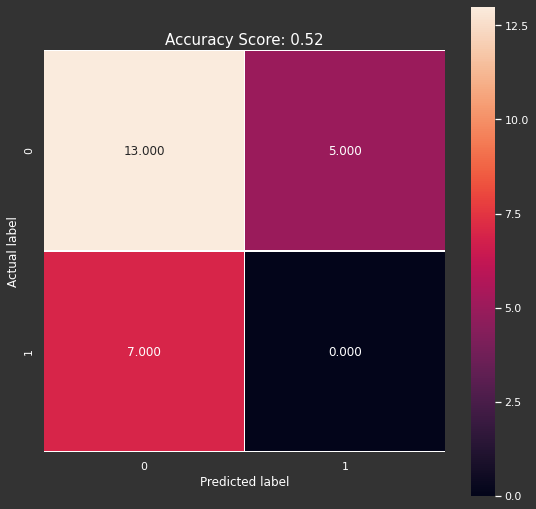

In [252]:
metrics.confusion_matrix(y, logreg.predict(X))


plt.figure(figsize=(9,9))
sns.heatmap(metrics.confusion_matrix(y, logreg.predict(X)), annot=True, fmt=".3f", linewidths=.5, square = True);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format((metrics.accuracy_score(y, logreg.predict(X))))
plt.title(all_sample_title, size = 15);
plt.savefig('Images/LogRegSurgeryHoldout.png',transparent=False,dpi=100,bbox_inches='tight', facecolor=('#333333'))
plt.show()

As we can see, there is a considerably lower accuracy when using this holdout set. Room for further improvement within the model exists

# Conclsions

The goal in creating our models was to give veterinarians and equine care staff an additional tool in gauging the severity of suspected colic in horses under their care. A reasonable level of accuracy has been achieved, given our limited data set, in attaining that goal. A rapid evaluation of the sick animal can be entered into our models to determine the severity of the illness and validate the decision to aggressively treat, and hopefully save the patient. The tough decision to commit to surgery and reduce the percentage of horses which perish from a lack of this intervention is our hope. With adoption of this model and an increase in observations, its strength in making accurate predictions can only increase.

Potential for model improvement:
    
    Increased size of data samples - Provider Participation.
    
    More insight - Using feature importance to incorporate new information into the model. 
    
    More modern teqniuqes - Incorporate things such as ultrasound image classification.